# Gathering Data

In [1]:
# Importing the needed libraries
import pandas as pd
import numpy as np
import requests
import os
import json
from pprint import pprint
import matplotlib.pyplot as plt
import re

In [2]:
# loading twitter-archive-enchanted.csv into DataFrame
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

In [3]:
#downloading image_prediction.tsv using requests
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

In [4]:
# loading image_predictions.tsv into DataFrame
image_predictions = pd.read_csv('image_predictions.tsv', sep = "\t")

In [5]:
# reading tweet-json.txt into JSON file
json_list = []
all_tweets = []
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweets = json.loads(line)
        tweet_id = tweets['id']
        retweet_count = tweets['retweet_count']
        favorite_count = tweets['favorite_count']
        json_list.append({'tweet_id': int(tweet_id),
                        'retweet_count': int(retweet_count),
                        'favorite_count': int(favorite_count),
                        'source': tweets['source'].split('>')[-2].strip('</a')})
        all_tweets.append(tweets)

In [6]:
# loading the JSON into DataFrame
tweet_json = pd.DataFrame(json_list)

# Assessing Data

In [7]:
# inspecting twitter_archive
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
# inspecting twitter_archive
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
# inspecting twitter_archive
twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [11]:
# inspecting twitter_archive
twitter_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [12]:
# inspecting twitter_archive
twitter_archive.expanded_urls.isna().sum()

59

In [13]:
# inspecting twitter_archive
twitter_archive[twitter_archive.expanded_urls.isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [14]:
# inspecting twitter_archive
twitter_archive['expanded_urls'].duplicated().sum()

137

twitter_archive.expanded_urls contains duplicates

In [15]:
# inspecting twitter_archive
twitter_archive[twitter_archive['expanded_urls'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sierra. She's one precious pupper. Abs...,NaN,NaN,NaN,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,667182792070062081,NaN,NaN,2015-11-19 03:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timison. He just told an awful joke bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667182792...,10,10,Timison,None,None,None,None
2293,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pipsy. He is a fluffball. Enjoys trave...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extremely intelligent dog here. Has learned to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
2298,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None


Viewing the duplicates

In [16]:
# inspecting twitter_archive
twitter_archive.loc[2, 'expanded_urls']

'https://twitter.com/dog_rates/status/891815181378084864/photo/1'

In [17]:
# inspecting twitter_archive
twitter_archive.loc[2212, 'expanded_urls']

'https://vine.co/v/ea0OwvPTx9l'

Some link/tweet are not directly from twitter

In [18]:
# inspecting twitter_archive
twitter_archive.query('expanded_urls == "https://vine.co/v/ea0OwvPTx9l"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
657,791774931465953280,NaN,NaN,2016-10-27 22:53:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Vine will be deeply missed. This was by far my...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,14,10,None,None,None,None,None
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Never forget this vine. You will not stop watc...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None


viewing the url that links to vine

In [19]:
# inspecting twitter_archive
twitter_archive[twitter_archive.rating_numerator.isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


No empty cell in the rating_numerator column

In [20]:
# inspecting twitter_archive
twitter_archive[twitter_archive.rating_denominator.isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


No empty cell in the rating.denominator column

In [21]:
# inspecting image_predictions
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [22]:
# inspecting image_predictions
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
# inspecting image_predictions
image_predictions.duplicated().sum()

0

image_predictions contains no duplicates

In [24]:
# inspecting tweet_json
tweet_json.head()

,tweet_id,retweet_count,favorite_count,source
0,892420643555336193,8853,39467,Twitter for iPhone
1,892177421306343426,6514,33819,Twitter for iPhone
2,891815181378084864,4328,25461,Twitter for iPhone
3,891689557279858688,8964,42908,Twitter for iPhone
4,891327558926688256,9774,41048,Twitter for iPhone


In [25]:
# inspecting tweet_json
tweet_json.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

showing the sources of each tweet

In [26]:
# inspecting tweet_json
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   int64 
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
 3   source          2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [27]:
# viewing a tweet in it's json form 
pprint(tweets)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'display_text_range': [0, 131],
 'entities': {'hashtags': [],
              'media': [{'display_url': 'pic.twitter.com/BLDqew2Ijj',
                         'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
                         'id': 666020881337073664,
                         'id_str': '666020881337073664',
                         'indices': [108, 131],
                         'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
                         'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
                         'sizes': {'large': {'h': 720,
                                             'resize': 'fit',
                                             'w': 960},
                                   'medium': {'h': 450,
                                              'resize': 'fit',
                                  

In [28]:
all_columns = pd.Series(list(twitter_archive)+list(image_predictions)+list(tweet_json))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
32      source
dtype: object

### Quality

**twitter_archive table:**
- removal of retweet rating rows
- removal of rows beyond August 1st, 2017
- in_reply_to_user_id, in_reply_to_status_id is not real tweet but reply to a real tweet
- missing expanded_urls
- erroneous datatype (timestamp column is string)
- source column contains unnecessary text attached to the source
- name column has missing values
- some names are not provided
- rating_denominator contain input order than 10
- rating_numerator contain input greater than 15
- Nulls represented as None in name, doggo, floofer, pupper and puppo columns


**tweet_json table:**
- source in string not category


### Tidiness


- four variables in four columns (doggo, floofer, pupper and puppo)
- twitter_archive and tweet_json should be together

# Functions For Project

In [29]:
def drop_rows(df, col):
    '''
    docstring: This function is used to drop rows which the column has value,
               it takes 2 positional arguments which are:
               1. Dataframe
               2. Column name
               
    inputs: The DataFrame, The column name to check for a condition.
    output: This function will create a new DataFrame
    '''
    
    return df.drop(df.loc[df[col] > 0].index, inplace=True)

In [30]:
def drop_rows_cond(df, col, string):
    '''
    docstring: This function is used to drop rows which the column has a particular value,
               it takes 3 positional arguments which are:
               1. Dataframe
               2. Column name
               3. The string to test the condition
               
    inputs: The DataFrame, The column name to check for a condition.
    output: This function will create a new DataFrame
    '''
    
    return df.drop(df.loc[df[col] == string].index, inplace=True)

In [31]:
def drop_rows_na(df, col):
    '''
    docstring: This function is used to drop rows which the column has value,
               it takes 2 positional arguments which are:
               1. Dataframe
               2. Column name
               
    inputs: The DataFrame, The column name with the null value(if any).
    output: This function will create a new DataFrame
    '''
    
    return df.dropna(subset = [col], inplace=True)

In [32]:
def drop_col(df, *args):
    '''
    docstring: This function is used to drop columns from a DataFrame,
               it takes at least 2 positional arguments which are:
               1. Dataframe
               2. Column name(s)
               
    inputs: The DataFrame, The columns to be dropped.
    output: This function will create a new DataFrame
    '''
    columns = []
    for column in args:
        columns.append(column)
    
    return df.drop(columns, axis = 1, inplace= True)

In [33]:
def rename(df, dic, col):
    '''
    docstring: This function is used to change the values of a column,
               it takes 3 positional arguments which are:
               1. Dataframe
               2. A dictionary containing the index(s) and new value(s)
               3. The Column name
               
    inputs: The DataFrame, The column name to check for a condition.
    output: This function changes the value of column that meets that criteria
    '''
    for id in archive_clean.index:
        if id in dic:
            df.loc[id, col] = dic[id]

# Cleaning Data

In [34]:
# Creating a copy of each DataFrame
archive_clean = twitter_archive.copy()
predictions_clean = image_predictions.copy()
json_clean = tweet_json.copy()

#### Define
- Dropping the rows that are retweets

#### Code

In [35]:
drop_rows(archive_clean, 'retweeted_status_id')

#### Test

In [36]:
archive_clean.shape

(2175, 17)

#### Define
- Dropping tweets beyond August 1st, 2017

#### Code

In [37]:
mask = (archive_clean['timestamp'] <= '2017-8-1')

In [38]:
mask

0       True
1       True
2       True
3       True
4       True
        ... 
2351    True
2352    True
2353    True
2354    True
2355    True
Name: timestamp, Length: 2175, dtype: bool

In [39]:
archive_clean = archive_clean[mask]

#### Test

In [40]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define

- Dropping the source column with the drop_col() fuunction

#### Code

In [41]:
drop_col(archive_clean, 'source')

#### Test

In [42]:
archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


#### Define
- Merging archive_clean and json_clean

#### Code

In [43]:
archive_clean = archive_clean.merge(json_clean, how = 'inner', on = 'tweet_id')

#### Test

In [44]:
archive_clean.shape

(2175, 19)

In [45]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853,39467,Twitter for iPhone
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514,33819,Twitter for iPhone
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328,25461,Twitter for iPhone
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964,42908,Twitter for iPhone
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774,41048,Twitter for iPhone


#### Define

- Dropping the rows that are not main tweets (i.e the tweet is a reply)

#### Code

In [46]:
drop_rows(archive_clean, 'in_reply_to_status_id')

#### Test

In [47]:
archive_clean.shape

(2097, 19)

In [48]:
archive_clean[archive_clean.in_reply_to_status_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source


#### Define

- Dropping `in_reply_to_status_id`,  `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` using the .drop() function

#### Code

In [49]:
drop_col(archive_clean, 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp')

#### Test

In [50]:
archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853,39467,Twitter for iPhone
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514,33819,Twitter for iPhone
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328,25461,Twitter for iPhone
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964,42908,Twitter for iPhone
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774,41048,Twitter for iPhone


#### Define

- Dropping the rows with missing expanded_urls link

#### Code

In [51]:
drop_rows_na(archive_clean, 'expanded_urls')

#### Test

In [52]:
archive_clean[archive_clean.expanded_urls.isna()]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source


#### Define

- Correcting timestamp column data type to datetime using pd.to_datetime()

#### code

In [53]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [54]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2174
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   text                2094 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2094 non-null   int64              
 5   rating_denominator  2094 non-null   int64              
 6   name                2094 non-null   object             
 7   doggo               2094 non-null   object             
 8   floofer             2094 non-null   object             
 9   pupper              2094 non-null   object             
 10  puppo               2094 non-null   object             
 11  retweet_count       2094 non-null   int64              
 12  favorite_count      2094 non-null 

#### Define
- Turning erroneous value in the name column to 'not given'

#### Code

In [55]:
err_name = set()
for name in archive_clean.name.unique():
    if name.islower() or len(name) == 1 or name == 'None':
        err_name.add(name)
print(err_name)
for error in err_name:
    archive_clean.name.replace(error, "not given", inplace = True)

{'officially', 'my', 'O', 'one', 'just', 'quite', 'all', 'a', 'by', 'incredibly', 'light', 'mad', 'getting', 'infuriating', 'his', 'unacceptable', 'the', 'very', 'life', 'old', 'this', 'space', 'such', 'not', 'None', 'actually', 'an'}


#### Test

In [56]:
no_name = archive_clean.query('name == "not given"')
no_name.sample(5)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source
1709,674781762103414784,2015-12-10 02:44:43+00:00,Bedazzled pup here. Fashionable af. Super yell...,https://twitter.com/dog_rates/status/674781762...,8,10,not given,None,None,None,None,1335,2169,Twitter for iPhone
448,806576416489959424,2016-12-07 19:09:37+00:00,Hooman catch successful. Massive hit by dog. F...,https://twitter.com/deadspin/status/8065709331...,13,10,not given,None,None,None,None,2230,5370,Twitter for iPhone
596,780931614150983680,2016-09-28 00:46:20+00:00,I want to finally rate this iconic puppo who t...,https://twitter.com/dog_rates/status/780931614...,13,10,not given,None,None,None,puppo,8536,24192,Twitter for iPhone
1211,700151421916807169,2016-02-18 02:54:41+00:00,If a pupper gave that to me I'd probably start...,https://twitter.com/dog_rates/status/700151421...,11,10,not given,None,None,pupper,None,754,2450,Twitter for iPhone
1514,681297372102656000,2015-12-28 02:15:26+00:00,This is actually a lion. We only rate dogs. Fo...,https://twitter.com/dog_rates/status/681297372...,12,10,not given,None,None,None,None,1091,3490,Twitter for iPhone


#### Define
- find missing names

#### Code

In [57]:
for index, text in enumerate(no_name.text):
    print(index, text, end = '\n\n')
#     break

0 Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh

1 When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq

2 Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm

3 I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba

4 You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV

5 This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp

6 I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk

7 Here we have a corgi undercover as a malamute. Pawbably doing import

In [58]:
name_index=[6, 14, 31, 33, 37, 44, 47, 57, 61, 68, 71, 94, 98, 132, 135, 136, 147, 158, 185, 213, 259, 280, 
            284, 327, 395, 419, 421, 434, 436, 498, 573, 597, 603, 607, 608, 610, 615, 619, 624, 631, 632, 
            634, 638, 643, 646, 647, 648, 650, 657, 662, 664, 667, 668]

len(name_index)

53

In [59]:
name_id = []
for i, index in enumerate(no_name.index):
    if i in name_index:
        name_id.append(index)
len(name_id)

53

In [60]:
pprint(name_id)

[33,
 68,
 138,
 146,
 154,
 174,
 192,
 235,
 259,
 293,
 310,
 421,
 442,
 613,
 624,
 625,
 689,
 737,
 817,
 890,
 1029,
 1095,
 1114,
 1244,
 1432,
 1499,
 1505,
 1550,
 1555,
 1679,
 1887,
 1949,
 1967,
 1982,
 1987,
 1998,
 2012,
 2025,
 2039,
 2053,
 2056,
 2058,
 2070,
 2076,
 2083,
 2086,
 2088,
 2092,
 2106,
 2123,
 2125,
 2130,
 2133]


In [61]:
name_found = ['howard', 'martha', 'boomer', 'zoey', 'meeko', 'cooper', 'wilson', 'kelvin', 'atlas', 'blue', 'grace', 'jake', 'dexter', 
              'loki', 'atlas', 'O\'malley', 'zoey', 'teagan', 'quizno', 'bretagne', 'taco', 'cletus', 'frank', 'hooman', 'tristan', 'thea', 
              'toby', 'hooman', 'sabertooth', 'squishy', 'rufus', 'hemry', 'alphred', 'alfredo', 'zeus', 'pancho', 'lerol', 'berta', 
              'chuk', 'smittens', 'alfonso', 'oliver', 'cheryl', 'jessiga', 'klint', 'Big jumpy rat', 'tickles', 'kohl', 'daryl', 'pepe', 
              'cupit', 'octaviath', 'john']
for i, name in enumerate(name_found):
    name_found[i] = name.title() # to make it look like name
name_found

['Howard',
 'Martha',
 'Boomer',
 'Zoey',
 'Meeko',
 'Cooper',
 'Wilson',
 'Kelvin',
 'Atlas',
 'Blue',
 'Grace',
 'Jake',
 'Dexter',
 'Loki',
 'Atlas',
 "O'Malley",
 'Zoey',
 'Teagan',
 'Quizno',
 'Bretagne',
 'Taco',
 'Cletus',
 'Frank',
 'Hooman',
 'Tristan',
 'Thea',
 'Toby',
 'Hooman',
 'Sabertooth',
 'Squishy',
 'Rufus',
 'Hemry',
 'Alphred',
 'Alfredo',
 'Zeus',
 'Pancho',
 'Lerol',
 'Berta',
 'Chuk',
 'Smittens',
 'Alfonso',
 'Oliver',
 'Cheryl',
 'Jessiga',
 'Klint',
 'Big Jumpy Rat',
 'Tickles',
 'Kohl',
 'Daryl',
 'Pepe',
 'Cupit',
 'Octaviath',
 'John']

In [62]:
name_dict = dict(zip(name_id, name_found))
pprint(name_dict)

{33: 'Howard',
 68: 'Martha',
 138: 'Boomer',
 146: 'Zoey',
 154: 'Meeko',
 174: 'Cooper',
 192: 'Wilson',
 235: 'Kelvin',
 259: 'Atlas',
 293: 'Blue',
 310: 'Grace',
 421: 'Jake',
 442: 'Dexter',
 613: 'Loki',
 624: 'Atlas',
 625: "O'Malley",
 689: 'Zoey',
 737: 'Teagan',
 817: 'Quizno',
 890: 'Bretagne',
 1029: 'Taco',
 1095: 'Cletus',
 1114: 'Frank',
 1244: 'Hooman',
 1432: 'Tristan',
 1499: 'Thea',
 1505: 'Toby',
 1550: 'Hooman',
 1555: 'Sabertooth',
 1679: 'Squishy',
 1887: 'Rufus',
 1949: 'Hemry',
 1967: 'Alphred',
 1982: 'Alfredo',
 1987: 'Zeus',
 1998: 'Pancho',
 2012: 'Lerol',
 2025: 'Berta',
 2039: 'Chuk',
 2053: 'Smittens',
 2056: 'Alfonso',
 2058: 'Oliver',
 2070: 'Cheryl',
 2076: 'Jessiga',
 2083: 'Klint',
 2086: 'Big Jumpy Rat',
 2088: 'Tickles',
 2092: 'Kohl',
 2106: 'Daryl',
 2123: 'Pepe',
 2125: 'Cupit',
 2130: 'Octaviath',
 2133: 'John'}


In [63]:
rename(archive_clean, name_dict, 'name')

#### Test

In [64]:
archive_clean.loc[2130, 'name']

'Octaviath'

In [65]:
archive_clean.loc[2039, 'name']

'Chuk'

In [66]:
archive_clean.loc[689, 'name']

'Zoey'

#### Define
- removing rows with no name

#### Code

In [67]:
drop_rows_cond(archive_clean, 'name', 'not given')

#### Test

In [68]:
archive_clean.query('name == "not given"')

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source


#### Define
- Changing all denominator to 10

#### Code

In [69]:
archive_clean.rating_denominator = 10

#### Test

In [70]:
archive_clean.rating_denominator.unique()

array([10])

#### Define
- Changing all numerator greater than 15 to 15

#### Code

In [71]:
archive_clean.query('rating_numerator > 15')#.index

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,source
429,810984652412424192,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,10,Sam,None,None,None,None,1655,5927,Twitter for iPhone
558,786709082849828864,2016-10-13 23:23:56+00:00,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None,7069,20296,Twitter for iPhone
617,778027034220126208,2016-09-20 00:24:34+00:00,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None,1885,7320,Twitter for iPhone
804,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None,2772,5569,TweetDeck
1024,716439118184652801,2016-04-03 01:36:11+00:00,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,10,Bluebert,None,None,None,None,247,2574,Twitter for iPhone
1095,709198395643068416,2016-03-14 02:04:08+00:00,"From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,10,Cletus,None,None,None,None,721,2634,Twitter for iPhone


In [72]:
index_list = [429, 558, 617, 804, 1024, 1095]
archive_clean.loc[429, 'rating_numerator'] = 15
archive_clean.loc[558, 'rating_numerator'] = 15
archive_clean.loc[617, 'rating_numerator'] = 15
archive_clean.loc[804, 'rating_numerator'] = 15
archive_clean.loc[1024, 'rating_numerator'] = 15
archive_clean.loc[1095, 'rating_numerator'] = 15

#### Test

In [73]:
archive_clean.rating_numerator.unique()

array([13, 12, 14,  5, 11,  6, 10, 15,  3,  8,  9,  4,  7,  2])

#### Define
- Changing all None in doggo, floofer, pupper and puppo columns to NaN using .replace() function

#### Code

In [74]:
archive_clean.replace('None', np.NaN, inplace=True)

#### Test

In [75]:
archive_clean.doggo.unique()

array([nan, 'doggo'], dtype=object)

In [76]:
archive_clean.floofer.unique()

array([nan, 'floofer'], dtype=object)

#### Define
- Changing None to the correct value in the dog stage columns

#### Code

In [77]:
archive_clean['stage'] = archive_clean.text.str.extract('(doggo|floofer|puppo|pupper)', expand=True)

#### Test

In [78]:
archive_clean.stage.value_counts()


pupper     127
doggo       42
puppo       21
floofer      3
Name: stage, dtype: int64

In [79]:
archive_clean.shape

(1442, 15)

#### Define
- dropping the `doggo, pupper, puppo, and floofer` columns

#### Code

In [80]:
drop_col(archive_clean, 'doggo', 'pupper', 'puppo', 'floofer')

#### Test

In [81]:
archive_clean.head(3)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,source,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8853,39467,Twitter for iPhone,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6514,33819,Twitter for iPhone,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4328,25461,Twitter for iPhone,NaN


#### Define
- changing source to category

#### Code

In [82]:
archive_clean.source = archive_clean.source.astype('category')

#### Test

In [83]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 0 to 2144
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1442 non-null   int64              
 1   timestamp           1442 non-null   datetime64[ns, UTC]
 2   text                1442 non-null   object             
 3   expanded_urls       1442 non-null   object             
 4   rating_numerator    1442 non-null   int64              
 5   rating_denominator  1442 non-null   int64              
 6   name                1442 non-null   object             
 7   retweet_count       1442 non-null   int64              
 8   favorite_count      1442 non-null   int64              
 9   source              1442 non-null   category           
 10  stage               193 non-null    object             
dtypes: category(1), datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 157.8+ KB


In [84]:
archive_clean.source.unique()

['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene', 'TweetDeck']
Categories (4, object): ['TweetDeck', 'Twitter Web Client', 'Twitter for iPhone', 'Vine - Make a Scene']

In [85]:
# to CSV files
archive_clean.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')
predictions_clean.to_csv('image_predictions_master.csv', index=False, encoding='utf-8')

## Visualization

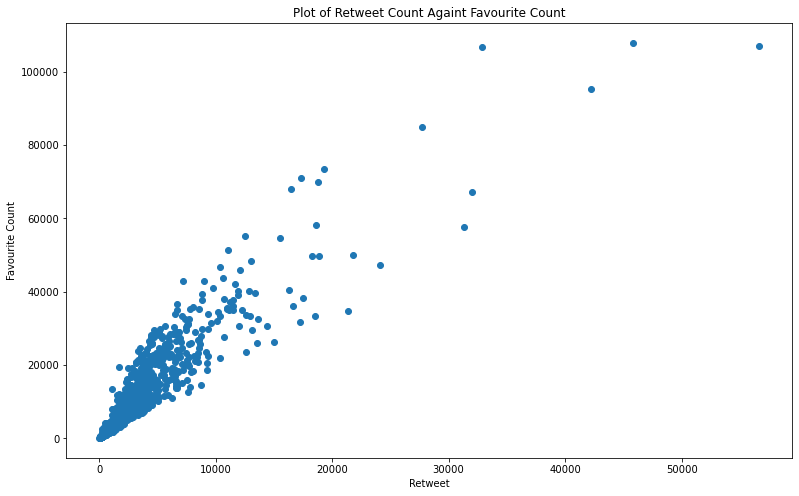

In [86]:
plt.figure(figsize=(13, 8))
plt.scatter(x = archive_clean.retweet_count, y = archive_clean.favorite_count)
plt.xlabel('Retweet')
plt.ylabel("Favourite Count")
plt.title("Plot of Retweet Count Againt Favourite Count");

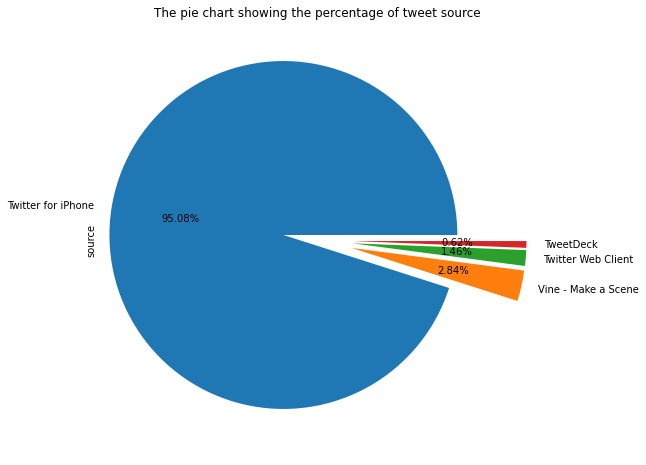

In [87]:
archive_clean['source'].value_counts().plot(kind = 'pie',
                                            figsize=[13, 8],
                                            explode= [0.2, 0.2 ,0.2, 0.2],
                                            autopct = '%1.2f%%',
                                            title = 'The pie chart showing the percentage of tweet source');

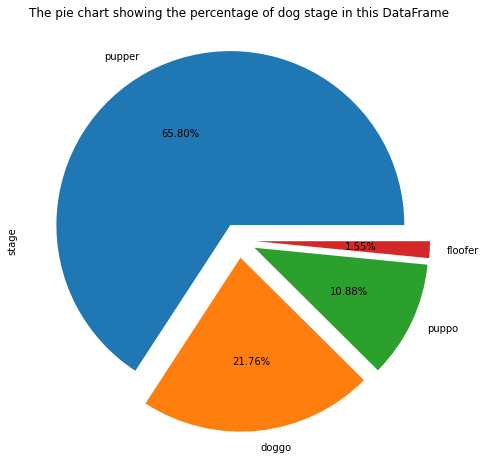

In [88]:
archive_clean['stage'].value_counts().plot(kind = 'pie',
                                            figsize=[13, 8],
                                            explode= [0.1, 0.1,0.1, 0.1],
                                            autopct = '%1.2f%%',
                                            title = 'The pie chart showing the percentage of dog stage in this DataFrame');

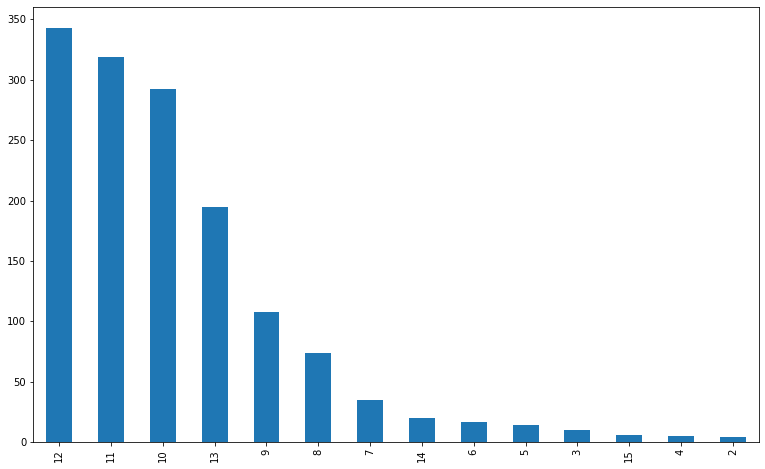

In [89]:
archive_clean.rating_numerator.value_counts().plot(kind = 'bar', figsize = (13, 8));